In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

sess = tf.InteractiveSession()
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Simple Gradients

Let's take the gradient of $ f(x) = x^2 $. The gradient should be 2x.

In [3]:
def f(x): return x**2
def grad_f(x): return 2*x
def numerical_grad_f(x, eps): 
  dely = f(x+eps)-f(x-eps)
  delx = (2*eps)
  return dely / delx

x = 9
eps= 1.0e-9
fx = f(x)
gradx = grad_f(x)
ngradx = numerical_grad_f(x, eps)
print("The calculated gradient of f(x) is {}, and the numerical gradient is {}".format(gradx, ngradx))

The calculated gradient of f(x) is 18, and the numerical gradient is 18.000001489326678


### Gradient in the Example

Let's take the gradient of $f(x) = ( x^3 + 5 )^2$. 

Using the chain rule, this is:

 \begin{align} 
 \frac{\partial f(x)}{\partial(x)} &= 2(x^3 + 5)3x^2  \\
 &= 6x^5 + 30x^2
 \end{align}
 
 But, you can also calculate it numerically! 
 
 \begin{align}
 \frac{\Delta f(x)}{\Delta x} = \frac{ f(x^+) - f(x^-)}{ x^+ - x^- }
 \end{align}
 
The numerical gradient is just taking a couple of points, and then seeing how they differ.
    
 
    
    
    

In [4]:
def f(x): return (x**3 + 5)**2
def grad_f(x): return (6*x**5+30*x**2)
def numerical_grad_f(x, eps): 
  dely = f(x+eps)-f(x-eps)
  delx = (2*eps)
  return dely / delx

x = 3
eps= 1.0e-9
fx = f(x)
gradx = grad_f(x)
ngradx = numerical_grad_f(x, eps)
print("The calculated gradient of f(x) is {}, and the numerical gradient is {}".format(gradx, ngradx))

The calculated gradient of f(x) is 1728, and the numerical gradient is 1728.0000292885234


### Using Tensorflow

Tensorflow has automatic differentiation, and there are tons of good [references](http://rail.eecs.berkeley.edu/deeprlcoursesp17/docs/tfsection.pdf) online. The basic idea is that the code creates a graph of operations and data (covered in class) and then puts those on the GPU.

In this exercise, using the Google tensorflow library, let's fit data to $\hat{y} = \sigma\left( wx + b \right)$. What does this graph look like?

#### Syntax

To create a variable, you would type in:

```w = tf.Variable(<initial-value>, name=<optional-name>)```

To create a placeholder (where you pass information onto the GPU), you type in

```x = tf.placeholder(<type>)```

Below, we initialize all the variables (really, just creating them). Now, there are variables residing on the GPU. If you want to use any of those variables, you'd need to tranfer them from the GPU to the CPU. 


In [5]:
def sigmoid( z ):
  return 1 / (1 + np.exp(-z))

def tf_sigmoid( z ):
  return 1 / (1 + tf.exp(-z))

# Placeholders for input and outputs
tf_x = tf.placeholder(tf.float32)
tf_y = tf.placeholder(tf.float32)

# Variables that you want to optimize. We're only using scalars
tf_w = tf.Variable(np.random.randn(), name='W_scalar')
tf_b = tf.Variable(np.random.randn(), name='b_scalar')

# The loss function we're using is the Mean Squared Error
tf_Loss = tf.reduce_mean( tf.square( tf_y - tf.sigmoid(tf_w * tf_x + tf_b) ) )
tf_dYdX = tf.gradients(tf_Loss, [tf_w, tf_b])

# Tensorflow allows us to simply use optimizers
optimizer = tf.train.AdamOptimizer(0.001)
tf_opt = optimizer.minimize(tf_Loss)

# Initialize and run all variables
sess.run(tf.global_variables_initializer())

### The Equivalent in Numpy

Numpy is a numerical library, which works on the CPU (and not the GPU). 

Text(0.5,0,'X (input)')

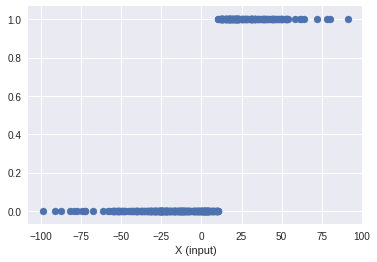

In [10]:
N = 500 # Number of points

# Initial parameters: Truth parameters
np_w = 0.5; np_b = -5

# Function for inference/generating data
def calculate_f(x, w, b, generate=False):
  # This is if you're generating any data. We'll be adding noise.
  if generate:
    return sigmoid( w*x + b ) + 0.05*np.random.randn(N)> 0.5
  # Otherwise, just evaluate it
  else:
    return sigmoid( w*x + b)
  
  # The loss function (as described in class)
def calculate_loss(x, y, w, b):
  return np.mean( ( y - sigmoid( w * x + b) )**2 ) 

# Here is some "truth" data
np_x = 30 * np.random.randn(N)
np_y = calculate_f(np_x, np_w, np_b, generate=True)

plt.scatter(np_x, np_y); plt.xlabel('X (input)')

### Calculate Tensorflow

To transfer variables to and from the GPU, you use the "run". Each "session" you have on the GPU box has a function `run`, which is an operation you command for the GPU access. To get a variable, for example, you would run: `CPU_VAR = sess.run(GPU_VAR)`.

You can also run the graph you created, by feeding in a dictionary. Look up the Tensorflow instructions to run a session with `feed_dict`. Calculate the gradient from our graph.

In [7]:
# Let's get the values from tensorflow
val_w = sess.run(tf_w)
val_b = sess.run(tf_b)

# Tensorflow gradients
val_dYdX = 0
print("Tensorflow calculated the gradients to be ", val_dYdX)

Tensorflow calculated the gradients to be  0


### Checking answers with Numpy

Now, check your tensorflow gradient with NUMPY.

In [8]:
# Numerical gradients from numpy
eps = 0.001

def numerical_gradient(x, y, w, b):
  return 0
# Analytical gradients
def calculate_gradient(x, y, w, b):
  return 0

# Print everything out
print("Analytical Gradient = ",calculate_gradient(np_x, np_y, val_w, val_b) )
print("Numpy calculated the gradients to be ", numerical_gradient(np_x, np_y, val_w, val_b))

Analytical Gradient =  0
Numpy calculated the gradients to be  0


Final value of w and b is  [0.507014, -5.3974977]


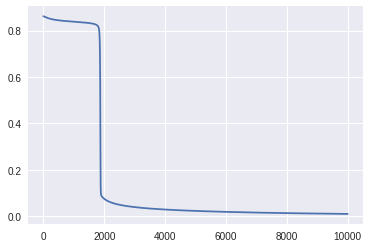

In [9]:
loss_array = []
for i in range(10000):
  optpair = sess.run([tf_opt, tf_Loss], feed_dict={tf_x: np_x, tf_y: np_y})
  loss_array += [optpair[1]]
plt.plot(loss_array)
print("Final value of w and b is ", sess.run([tf_w, tf_b]))